## Сегментация изображений на два класса с использованием модели DeepLab на датасете Pascal VOC

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
# Загрузка датасета Pascal VOC
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "JPEGImages")
    masks_dir = os.path.join(dataset_dir, "SegmentationClass")

    image_filenames = os.listdir(images_dir)
    image_paths = [os.path.join(images_dir, fname) for fname in image_filenames]
    mask_paths = [os.path.join(masks_dir, fname.split(".")[0] + ".png").replace("\\", "/") for fname in image_filenames]

    images = []
    masks = []
    for image_path, mask_path in zip(image_paths, mask_paths):
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = np.where(mask > 0.5, 1, 0)
        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [3]:
def create_deeplab_model(input_shape, num_classes):
    base_model = tf.keras.applications.Xception(input_shape=input_shape, include_top=False)
    base_model_output = base_model.get_layer("block13_sepconv2_act").output
    x = layers.Conv2D(num_classes, (1, 1), activation="softmax", padding='same')(base_model_output)
    resized_output = tf.image.resize(x, (256, 256))
    model = tf.keras.Model(inputs=base_model.input, outputs=resized_output)
    return model

In [4]:
def train_model(model, train_images, train_masks, epochs, batch_size):
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(train_images, train_masks, batch_size=batch_size, shuffle=True)
    steps_per_epoch = len(train_images) // batch_size
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)
    return history

In [5]:
def evaluate_model(model, test_images, test_masks):
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(test_images, test_masks, batch_size=1, shuffle=False)
    loss, accuracy = model.evaluate(test_generator, steps=len(test_images))
    print("Потеря на тестовых данных: {:.4f}".format(loss))
    print("Точность модели на тестовых данных: {:.2f}%".format(accuracy * 100))

In [6]:
def visualize_results(images, masks, model):
    num_samples = 4
    random_indices = np.random.choice(len(images), size=num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))

    for i, index in enumerate(random_indices):
        sample_image = images[index]
        prediction = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_mask = np.argmax(prediction, axis=-1)

        axes[i, 0].imshow((sample_image * 255).astype(np.uint8))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Тестовое изображение')

        axes[i, 1].imshow(predicted_mask.squeeze(), cmap="gray")
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Маска сегментации')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_loss_and_accuracy(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, loss, 'b', label='Потеря на обучающей выборке')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Потеря')
    axes[0].legend()

    axes[1].plot(epochs, accuracy, 'r', label='Точность на обучающей выборке')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Параметры обучения
dataset_dir = './VOCdevkit/VOC2012'
epochs = 10
batch_size = 8

In [9]:
# Загрузка датасета
images, masks = load_dataset(dataset_dir)

In [10]:
# Разделение на обучающую и тестовую выборки
split_index = int(0.8 * len(images))
train_images, test_images = images[:split_index], images[split_index:]
train_masks, test_masks = masks[:split_index], masks[split_index:]

In [11]:
# Создание модели
input_shape = train_images[0].shape
num_classes = 2
model = create_deeplab_model(input_shape, num_classes)

In [12]:
# Обучение модели
history = train_model(model, train_images, train_masks, epochs, batch_size)

Epoch 1/10
291/291 [==============================] - 739s 3s/step - loss: 0.3462 - accuracy: 0.7410
Epoch 2/10
291/291 [==============================] - 734s 3s/step - loss: 0.2743 - accuracy: 0.7251
Epoch 3/10
291/291 [==============================] - 738s 3s/step - loss: 0.2255 - accuracy: 0.7179
Epoch 4/10
291/291 [==============================] - 741s 3s/step - loss: 0.1956 - accuracy: 0.7114
Epoch 5/10
291/291 [==============================] - 790s 3s/step - loss: 0.1809 - accuracy: 0.7095
Epoch 6/10
291/291 [==============================] - 763s 3s/step - loss: 0.1499 - accuracy: 0.7066
Epoch 7/10
291/291 [==============================] - 727s 3s/step - loss: 0.1339 - accuracy: 0.7059
Epoch 8/10
291/291 [==============================] - 741s 3s/step - loss: 0.1255 - accuracy: 0.7053
Epoch 9/10
291/291 [==============================] - 836s 3s/step - loss: 0.1594 - accuracy: 0.7082
Epoch 10/10
291/291 [==============================] - 1093s 4s/step - loss: 0.1308 - accur

In [13]:
# Оценка модели
evaluate_model(model, test_images, test_masks)

583/583 [==============================] - 88s 149ms/step - loss: 0.4286 - accuracy: 0.6737
Потеря на тестовых данных: 0.4286
Точность модели на тестовых данных: 67.37%


1/1 [==============================] - 0s 215ms/step


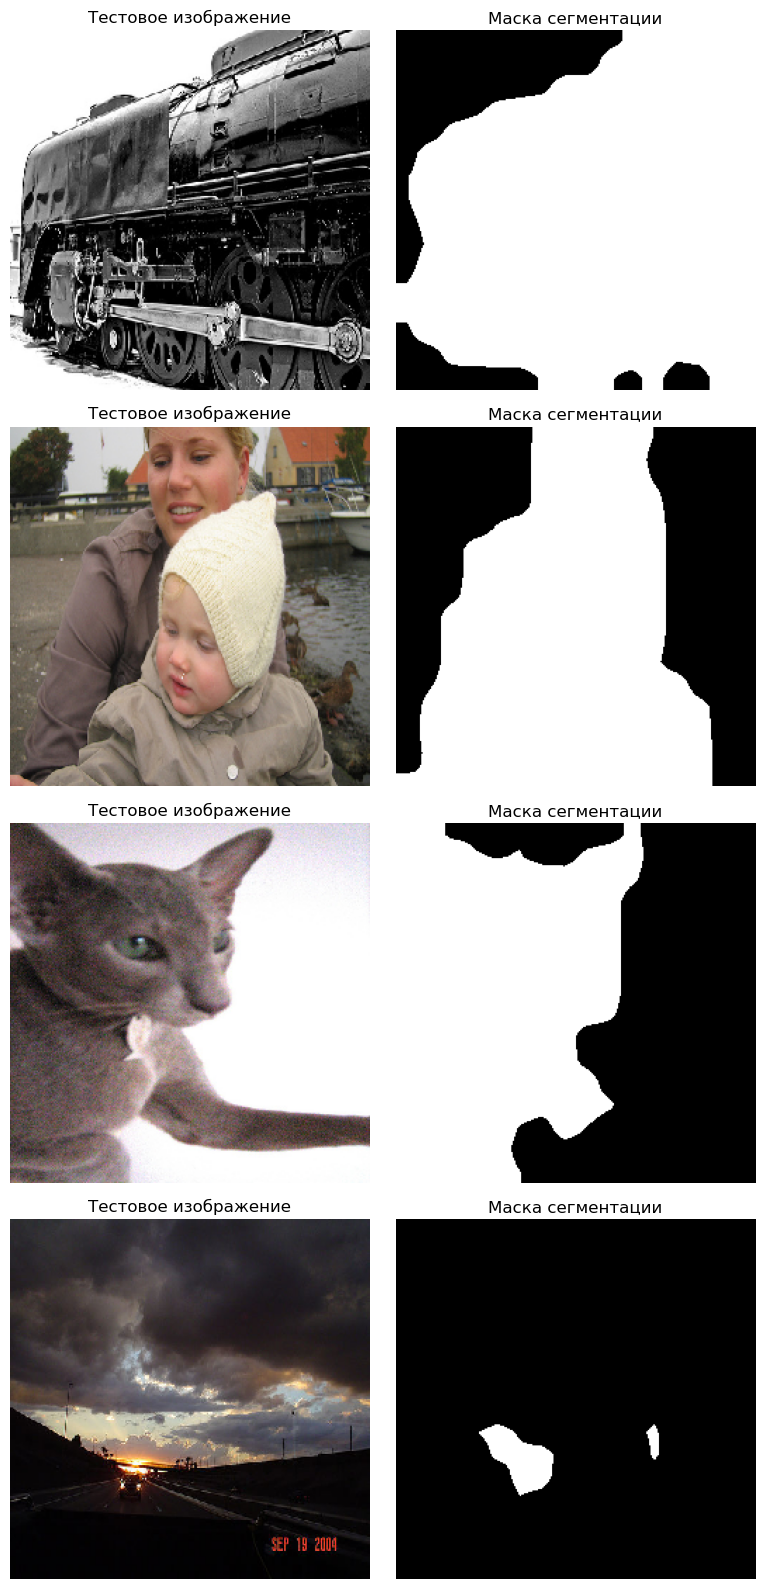

In [14]:
# Визуализация результатов
visualize_results(test_images, test_masks, model)

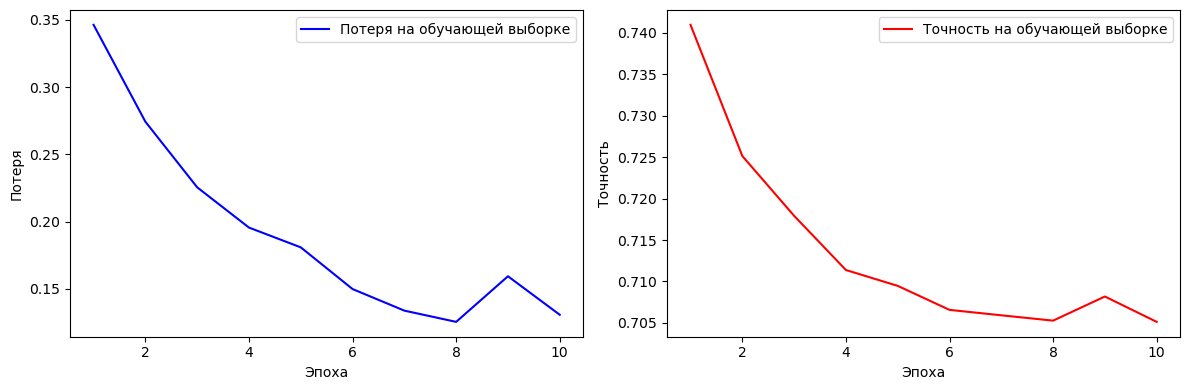

In [15]:
# Вывод графика потерь и точности на обучающей выборке
plot_loss_and_accuracy(history)

## Анализ кода:
1. Импортируются необходимые библиотеки TensorFlow, NumPy, os и matplotlib.
2. Определена функция `load_dataset`, которая загружает датасет Pascal VOC. Она считывает изображения и маски из соответствующих директорий, изменяет их размер до 256x256 пикселей, нормализует изображения и преобразует маски в двоичный формат (0 и 1). Затем функция возвращает массивы изображений и масок.
3. Определена функция `create_deeplab_model`, которая создает модель DeepLab для сегментации изображений. Она использует предварительно обученную модель Xception и добавляет свой слой классификации с использованием функции активации softmax. Размеры выходного изображения изменяются до 256x256 пикселей. Функция возвращает модель.
4. Определена функция `train_model`, которая обучает модель. Она использует генераторы данных изображений для создания пакетов обучающих данных. Модель компилируется с оптимизатором Adam и функцией потерь "sparse_categorical_crossentropy". Затем модель обучается на данных с помощью функции `fit`. Функция возвращает историю обучения модели.
5. Определена функция `evaluate_model`, которая оценивает модель на тестовых данных. Она использует генератор данных для создания пакетов тестовых данных и вычисляет потерю и точность модели с помощью функции `evaluate`.
6. Определена функция `visualize_results`, которая визуализирует результаты модели на тестовых данных. Она выбирает несколько случайных изображений из тестового набора, применяет модель для получения предсказанных масок сегментации и отображает оригинальные изображения и предсказанные маски.
7. Определена функция `plot_loss_and_accuracy`, которая строит графики потерь и точности модели на обучающей выборке во время обучения.

## Параметры, которые улучшают обучение нейронной сети:
- Увеличение количества эпох (`epochs`) может улучшить точность модели, но может также увеличить время обучения.
- Увеличение размера пакета (`batch_size`) может ускорить обучение, но при этом может потребоваться больше памяти.
- Использование предварительно обученной модели с более высокой точностью (например, использование другой базовой модели) может улучшить точность модели.

## Параметры, которые ухудшают обучение нейронной сети:
- Уменьшение количества эпох (`epochs`) может ускорить обучение, но может также ухудшить точность модели.
- Уменьшение размера пакета (`batch_size`) может уменьшить требования к памяти, но при этом может замедлить обучение и ухудшить точность модели.
- Использование предварительно обученной модели с более низкой точностью может ухудшить точность модели.
- Изменение размера входных изображений (`target_size` в функции `load_img`) может повлиять на точность модели, поскольку изменение масштаба может влиять на информацию, передаваемую модели.